In [ ]:
from nltk import sent_tokenize, pos_tag
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.util import mark_negation
from string import punctuation
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/haoyuechen/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## SentiWordNet Sentiment Scoring

Here we write a function to convert between the PennTreebank tags to simple Wordnet tags:

In [2]:
def penn_to_wordnet(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

Now we write a function to get sentiment score, this will return the sentiment score of a given text using SentiWordNet sentiment scores.

In [3]:
def get_sentiment_score(text):
       
    total_score = 0
    raw_sentences = sent_tokenize(text)
    
    for sentence in raw_sentences:

        sent_score = 0     
        sentence = str(sentence)
        sentence = sentence.replace("<br />"," ").translate(str.maketrans('','',punctuation)).lower()
        tokens = TreebankWordTokenizer().tokenize(text)
        tags = pos_tag(tokens)
        for word, tag in tags:
            wordnet_tag = penn_to_wordnet(tag)
            if not wordnet_tag:
                continue
            lemma = WordNetLemmatizer().lemmatize(word, pos=wordnet_tag)
            if not lemma:
                continue
            synsets = wn.synsets(lemma, pos=wordnet_tag)
            if not synsets:
                continue
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sent_score += swn_synset.pos_score() - swn_synset.neg_score()

        total_score = total_score + (sent_score / len(tokens))

    
    return (total_score / len(raw_sentences)) * 100

## Data Analysis

In [5]:
reviews = pd.read_csv("small_corpus.csv")

In [7]:
reviews.shape

(4500, 12)

In [8]:
reviews.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,1.0,4.0,False,"01 21, 2015",AP36MGWFVXAJG,B00MV9FCFQ,NaN,Lois Kilmister,This has failed me 3 times to work very unsatisfled with this.,Failure,1421798400,NaN
1,1.0,NaN,True,"01 31, 2016",A92HIQFVSBZXU,B019GIOH7S,NaN,Martin,i basically got robbed by the lady i gave this too,One Star,1454198400,NaN
2,1.0,NaN,True,"02 2, 2017",A1SFQQE7YYW4LH,B00MV9P8MS,NaN,Amazon Customer,"This is terrible. I purchased 50$ before Christmas for my mother and when she tried to use it today , it said it only had 25.98$ on it. Someone had used it according to the cashier. This is horrible and I want our money back. This is stealing!",Bought 50$ but only showed $25.98. You stole my money.,1485993600,NaN
3,1.0,NaN,True,"01 25, 2018",A2XREU38W4XMI4,B00BXQIGA6,NaN,Betty,This also was a gift card for someone else .,One Star,1516838400,NaN
4,1.0,NaN,True,"10 25, 2016",A32YOODBMFSDNU,B00PG8502O,NaN,Janet Kay Lee,It was returned to me and not delivered. So no it didn't meet my expectations. No I didn't lose any money but I had to go out and get another one at a store and missed the Anniversary date.,Returned,1477353600,NaN


In [9]:
reviews.dropna(subset=['reviewText'],inplace=True)

In [10]:
reviews.shape

(4498, 12)

In [17]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/haoyuechen/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [19]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/haoyuechen/nltk_data...


True

In [21]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/haoyuechen/nltk_data...


True

In [23]:
nltk.download('sentiwordnet')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/haoyuechen/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

In [24]:
reviews['swn_score'] = reviews['reviewText'].apply(lambda text : get_sentiment_score(text))

In [26]:
reviews[['reviewText','swn_score']].sample(2)

,reviewText,swn_score
499,Could have been a bit clearer that it could only be used on the .com website. For anyone non US based gift cards are a bit impractical,0.000
984,Both cards are not activated. I cannot redeem them on itunes. ITunes saysomething the cards are not activated.,-9.375


<AxesSubplot:xlabel='swn_score', ylabel='Count'>

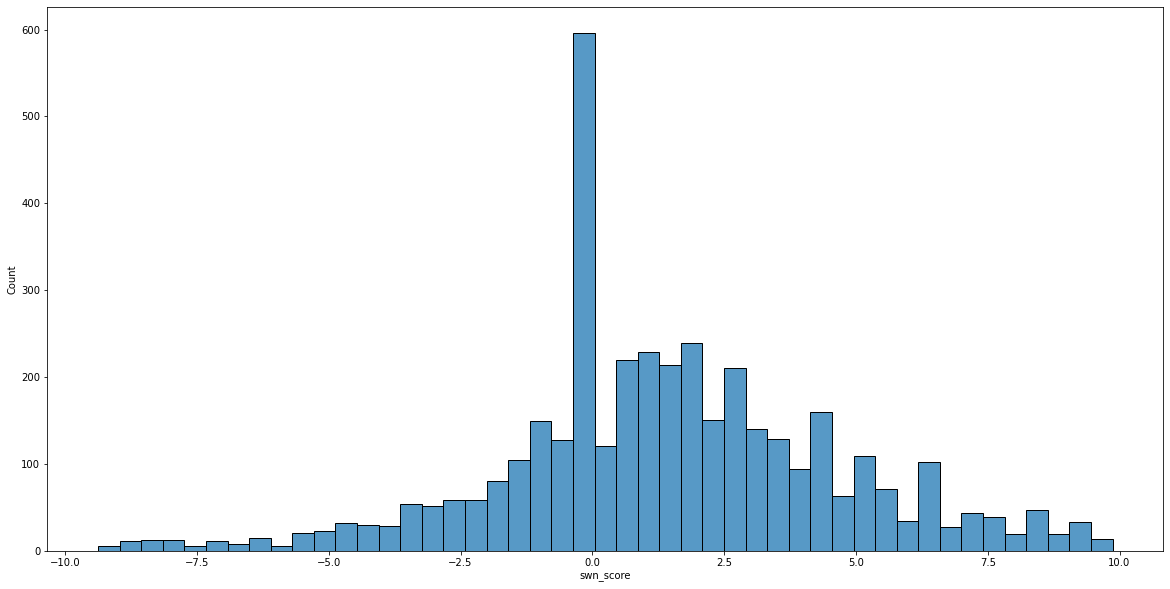

In [30]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
sns.histplot(x='swn_score',data=reviews.query("swn_score < 10 and swn_score > -10"), ax=ax)

In [31]:
reviews['swn_sentiment'] = reviews['swn_score'].apply(lambda x: "positive" if x>1 else ("negative" if x<0.5 else "neutral"))

In [37]:
reviews['swn_sentiment'].value_counts()

positive    2497
negative    1721
neutral      280
Name: swn_sentiment, dtype: int64

<AxesSubplot:xlabel='overall', ylabel='count'>

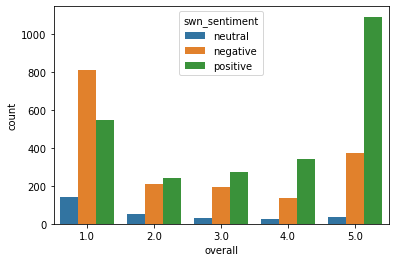

In [40]:
sns.countplot(x='overall',hue='swn_sentiment',data=reviews)

<AxesSubplot:xlabel='swn_sentiment', ylabel='overall'>

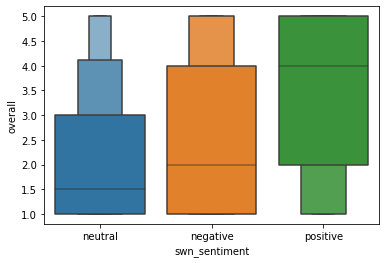

In [41]:
sns.boxenplot(x='swn_sentiment',y='overall',data=reviews)

<AxesSubplot:xlabel='overall', ylabel='swn_score'>

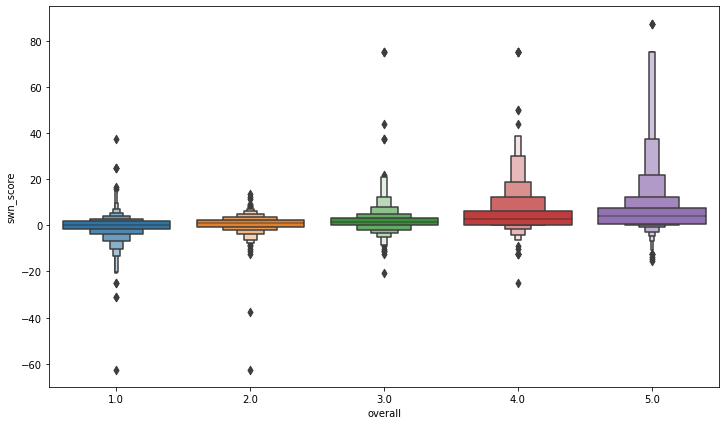

In [48]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
sns.boxenplot(x='overall',y='swn_score',data=reviews,ax=ax)

In [49]:
reviews['true_sentiment'] = reviews['overall'].apply(lambda x:"positive" if x>=4 else ("neutral" if x==3 else "negative"))

In [58]:
y_swn_pred= reviews['swn_sentiment'].tolist()

In [60]:
y_true = reviews['true_sentiment'].tolist()

In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_swn_pred)

from sklearn.metrics import classification_report

Text(81.96000000000004, 0.5, 'True')

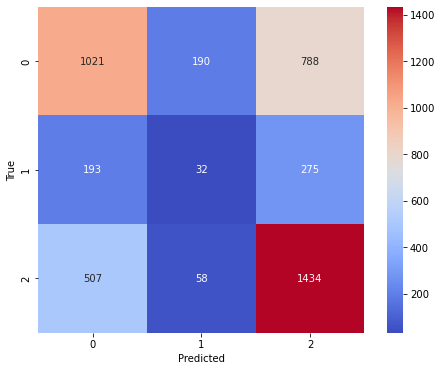

In [71]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
sns.heatmap(cm,cmap='coolwarm',annot=True,fmt='d',square=True,ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [73]:
print(classification_report(y_true,y_swn_pred))

              precision    recall  f1-score   support

    negative       0.59      0.51      0.55      1999
     neutral       0.11      0.06      0.08       500
    positive       0.57      0.72      0.64      1999

    accuracy                           0.55      4498
   macro avg       0.43      0.43      0.42      4498
weighted avg       0.53      0.55      0.54      4498



In [78]:
# Sentiment Scoring Model Using NLTK Opinion Lexicon
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize, sent_tokenize

In [79]:
nltk.download("opinion_lexicon")

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/haoyuechen/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


True

In [83]:
pos_words = list(opinion_lexicon.positive())
neg_words = list(opinion_lexicon.negative())

Now we return the sentiment score of a given text using nltk opinion lexicon:

In [84]:
def get_sentiment_score_oplex(text): 
    total_score = 0

    raw_sentences = sent_tokenize(text)
    
    for sentence in raw_sentences:

        sent_score = 0     
        sentence = str(sentence)
        sentence = sentence.replace("<br />"," ").translate(str.maketrans('','',punctuation)).lower()
        tokens = TreebankWordTokenizer().tokenize(text)
        for token in tokens:
            sent_score = sent_score + 1 if token in pos_words else (sent_score - 1 if token in neg_words else sent_score)
        total_score = total_score + (sent_score / len(tokens))

    
    return total_score

In [87]:
reviews['oplex_sentiment_score'] = reviews['reviewText'].apply(lambda x: get_sentiment_score_oplex(x))

<AxesSubplot:xlabel='oplex_sentiment_score', ylabel='Count'>

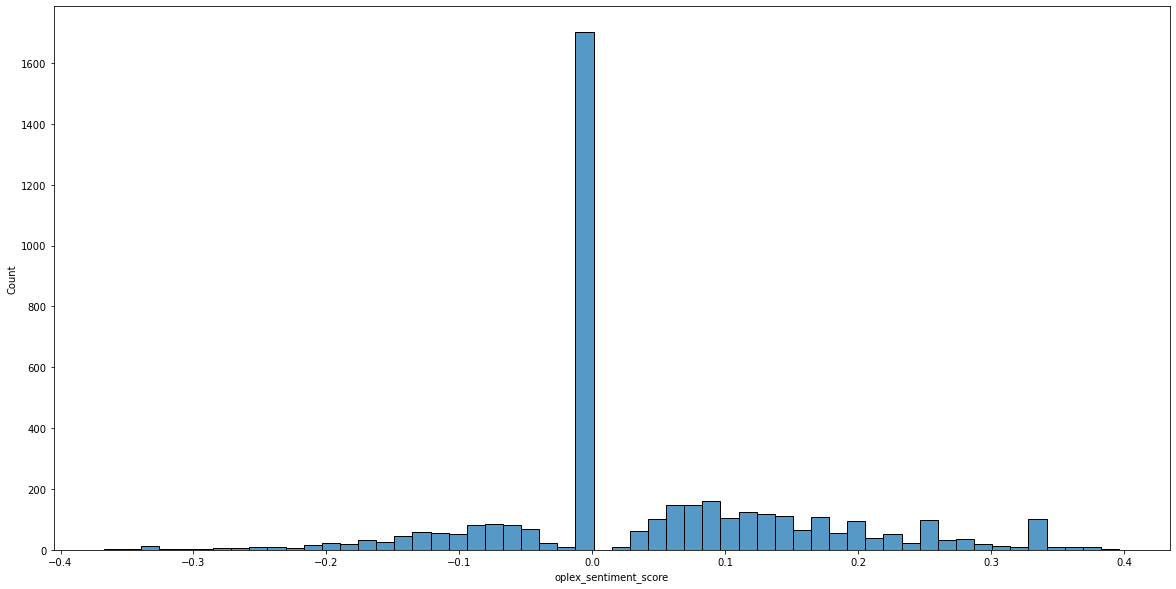

In [91]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
sns.histplot(x='oplex_sentiment_score',data=reviews.query("oplex_sentiment_score < 0.4 and oplex_sentiment_score>-0.4"), ax=ax)

In [92]:
reviews['oplex_sentiment'] = \
    reviews['oplex_sentiment_score'].apply(lambda x: "positive" if x>0.1 else ("negative" if x<0 else "neutral"))

In [93]:
reviews['oplex_sentiment'].value_counts(dropna=False)

neutral     2381
positive    1355
negative     762
Name: oplex_sentiment, dtype: int64

<AxesSubplot:xlabel='overall', ylabel='count'>

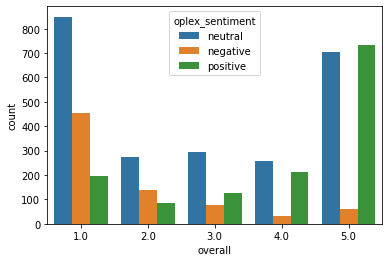

In [94]:
sns.countplot(x='overall', hue='oplex_sentiment' ,data = reviews)

<AxesSubplot:xlabel='oplex_sentiment', ylabel='overall'>

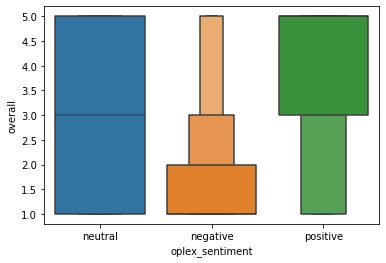

In [95]:
sns.boxenplot(x='oplex_sentiment', y='overall', data = reviews)

<AxesSubplot:xlabel='overall', ylabel='oplex_sentiment_score'>

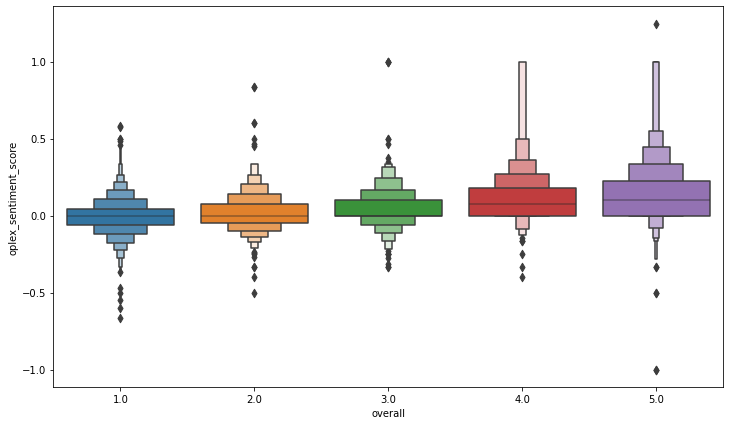

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12,7))
sns.boxenplot(x='overall', y='oplex_sentiment_score', data = reviews, ax=ax)

In [97]:
y_oplex_pred = reviews['oplex_sentiment'].tolist()

In [98]:
oplex_cm = confusion_matrix(y_true, y_oplex_pred)

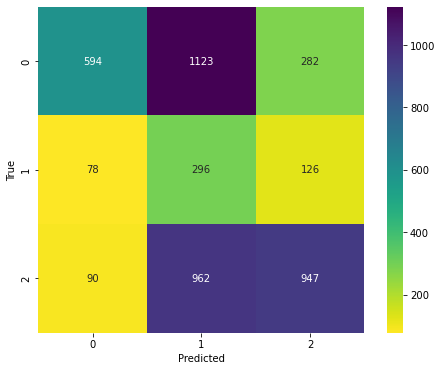

In [101]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
sns.heatmap(oplex_cm, cmap='viridis_r', annot=True, fmt='d', square=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [102]:
oplex_cm

array([[ 594, 1123,  282],
       [  78,  296,  126],
       [  90,  962,  947]])

In [103]:
print(classification_report(y_true,y_oplex_pred))

              precision    recall  f1-score   support

    negative       0.78      0.30      0.43      1999
     neutral       0.12      0.59      0.21       500
    positive       0.70      0.47      0.56      1999

    accuracy                           0.41      4498
   macro avg       0.53      0.45      0.40      4498
weighted avg       0.67      0.41      0.47      4498

